# Practical Session : Flights Dataset Analysis

Mathilde Da Cruz and Etienne Cartier

In this session, we will conduct a few analyses on a simplified flight fares dataset.  
In particular we will try to build cheapest routes from one point to another.

## Grading and Instructions



You must return your notebook before **Sunday March 6th 23:59 Paris time** by email to David : d.diebold@criteo.com.  
Grade will be composed of :
1. Timely return
2. Correctness (some questions may still leave you with some liberties)
3. Report formatting : While we allow you to return your project in a notebook format, you should think your report as being a classic text and image pdf report in which the code is in appendix. That means your notebook should be fully readable while hiding all the code cells.
4. Code Readability (factorized code, well-named variables, explain what you do when code becomes complicated, etc...)
5. Performance (this is not a race but we want you to think about performance issues when designing your solution (shuffles, etc...). Don't hesitate to annotate your notebook with any remarks about your solution.

## Install Spark Environment 


Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.  
We need to install Spark, as well as a Java Runtime Environment.  
Then we need to setup a few environment variables. 

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   164M      0  0:00:01  0:00:01 --:--:--  164M


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

## Optional step : Enable SparkUI through secure tunnel


This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.


In [4]:
# this step downloads ngrok, configures your AuthToken, then starts the tunnel
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken 25SyKsSNT9ahWjGdFfYbTx18g1I_qNiCCcS4WQFwwEmU2osb 
get_ipython().system_raw('./ngrok http 4050 &')

--2022-03-06 20:56:25--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  8.46MB/s    in 1.6s    

2022-03-06 20:56:27 (8.46 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


Now get the Spark UI url on https://dashboard.ngrok.com/endpoints/status. We're done !

## Useful imports

In [5]:
import time
import numpy as np
import pyspark.sql.functions as F
%matplotlib inline

In [6]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 235 kB/s 
     |████████████████████████████████| 6.3 MB 32.3 MB/s 


In [7]:
pip install shapely

In [8]:
pip install pyspark-dist-explore

In [9]:
from pyspark.sql.types import Row

import pandas as pd
import geopandas
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import numpy as np

from pyspark.sql.functions import lit, size

from pyspark.sql import Window

## Introduction

Aim of this notebook is to help you get comfortable with Spark Dataframe API while working on a flights dataset.  
This dataset contains some domestic flight prices for US country.  
We will call route a tuple identified by an origin airport and a destination airport.  
We will try to find-out what are the best options for a traveler, to go from some place to another.  
Here is a short description of the columns:
- ItinID & MktID: vaguely demonstrates the order in which tickets were ordered (lower ID #'s being ordered first)
- MktCoupons: the number of coupons in the market for that flight
- Quarter: 1, 2, 3, or 4, all of which are in 2018
- Origin: the city out of which the flight begins
- OriginWac: USA State/Territory World Area Code
- Dest: the city out of which the flight begins
- DestWac: USA State/Territory World Area Code
- Miles: the number of miles traveled
- ContiguousUSA: binary column -- (2) meaning flight is in the contiguous (48) USA states, and (1) meaning it is not (ie: Hawaii, Alaska, off-shore territories)
- NumTicketsOrdered: number of tickets that were purchased by the user
- Airline Company: the two-letter airline company code that the user used from start to finish (key codes below)
- PricePerTicket: ticket price

In [10]:
# download the dataset described above
from urllib import request
import zipfile

url = "https://www.dropbox.com/s/kda4h5su4z6go05/flights.zip?dl=1"
filehandle, _ = request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.extractall()

In [11]:
# This second file contains a mapping with airports Code / Name / Latitude / Longitude
# It can help to get a better understanding of the airports you are dealing with.
# Source : https://www.partow.net/miscellaneous/airportdatabase/index.html#Downloads
url2 = "https://www.dropbox.com/s/xe2a3hgwlugos7a/GlobalAirportDatabase.txt?dl=1"
request.urlretrieve(url2, "airport_latlon.txt")

('airport_latlon.txt', <http.client.HTTPMessage at 0x7f0145f42690>)

In [12]:
!ls

airport_latlon.txt	      sample_data
Cleaned_2018_Flights.csv      spark-3.2.1-bin-hadoop3.2
ngrok			      spark-3.2.1-bin-hadoop3.2.tgz
ngrok-stable-linux-amd64.zip


## Question 1 (1 point)

**Task : Display a few rows of the flights fare dataset, display it's schema, and count the amount of rows.  
You are likely to read this dataset a lots of times ; rewrite the dataset on the file system in an optimized way, to optimize further readings.**

####Answer and code :

First, we decided to import and rewrite our dataset as a parquet file. Indeed, Parquet allows to consume less space and is very efficient for column prunning especially (even if won't beneficiate from it that much because we are going to read all columns). Parquet also provides other optimisations for some tasks and queries.

When we read it for the first time we set the parameter ```inferSchema``` to ```True``` so that we have more representative data types (instead of ```string``` for every type). The parquet format will help remembering it without having to read the full dataset to infer the schema each time)

Then we use ```.cache()``` in order to set the default storage to the memory and disk. We can do it here because our dataset is not so large.


We note that using the parquet format allows us to count the number of samples more than 10 times faster.

Finally, we have our cached dataset ```flights_df``` (read from parquet).

We can then use method ```.count()``` and find that we have 9534417 rows.

Then, we can use ```printSchema()``` method and see the resulting infered schema (which seems ok yet non optimized). We could have defined the schema by ourselves, but because we don't have that many data, and because it only took 1min22 to read it while inferring the schema, we just let it this way.

Finally, with ```.show(5)``` we can display the 5 first rows.



In [13]:
flights_parquet_path = "flights.parquet"
%time spark.read.options(header=True).csv('Cleaned_2018_Flights.csv', inferSchema=True).write.parquet(flights_parquet_path)

CPU times: user 526 ms, sys: 70.7 ms, total: 597 ms
Wall time: 1min 36s


In [14]:
%time flights_df = spark.read.parquet(flights_parquet_path)

CPU times: user 4.77 ms, sys: 313 µs, total: 5.08 ms
Wall time: 304 ms


In [15]:
flights_df.cache()

DataFrame[_c0: int, ItinID: bigint, MktID: bigint, MktCoupons: int, Quarter: int, Origin: string, OriginWac: int, Dest: string, DestWac: int, Miles: double, ContiguousUSA: int, NumTicketsOrdered: double, AirlineCompany: string, PricePerTicket: double]

In [16]:
%time print(f'There are {flights_df.count()} row in the dataset.')

There are 9534417 row in the dataset.
CPU times: user 115 µs, sys: 29 µs, total: 144 µs
Wall time: 150 µs


In [17]:
flights_df.printSchema()
flights_df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- ItinID: long (nullable = true)
 |-- MktID: long (nullable = true)
 |-- MktCoupons: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestWac: integer (nullable = true)
 |-- Miles: double (nullable = true)
 |-- ContiguousUSA: integer (nullable = true)
 |-- NumTicketsOrdered: double (nullable = true)
 |-- AirlineCompany: string (nullable = true)
 |-- PricePerTicket: double (nullable = true)

+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+--------------+--------------+
|_c0|     ItinID|        MktID|MktCoupons|Quarter|Origin|OriginWac|Dest|DestWac| Miles|ContiguousUSA|NumTicketsOrdered|AirlineCompany|PricePerTicket|
+---+-----------+-------------+----------+-------+------+---------+----+-------+------+-------------+-----------------+-----

## Question 2 (4 points)

**Task : Find how many origin and destination airports are contained in the dataset.  
Show them on a US map to get a better intuition of the dataset. You can use shapely and geopandas to perform this task.  
Do we have all the lat/lon available ?**

#### Answer and code :

In order to find how many origin and destination airports are contained in the dataset, we create a new dataframe containing only the column of interest ('Origin' or 'Dest') using the method ```.select('col')```. Then ```.distinct()``` allows us to keep only distinct elements. Finally we just have to ```.count()``` them.

We find that there are 263 origin airports for 260 destination aiports, for a total of 270 different aiports.

Now, we can use the file ```airport_latlon.txt```. We import it while precising the schema (thanks to the informations of the origin website), and then we can join it with our dataframe of airports. Spark is quite efficient with the joins ($n*log(n)$ complexity).

We note that Origins and destinations in the flights dataset correspond to the _c2 column (IATA code).

We use an ```INNER``` join, so that we only keep the joined rows (ie. the rows for which there is a correspondance between the two sets).

Now we can count the number of rows of our ```airports_loc``` dataframe and note that we have the latitude and longitude for only 177 of our airports (over 270).

In order to represent our airports on a map of the USA,  we import the geopandas forms of the countries of the world and then only keep polygons representing USA.

We can transform our ```airports_loc``` spark dataframe to a pandas dataframe in order to transform the lat/lon coordinates into points. We can do this because there are only 177 rows in our dataset, which is totally reasonnable for a pandas dataframe on a single computer (we do not import too many data on the driver).

We use the line ```gdf = geopandas.GeoDataFrame(air, geometry=geopandas.points_from_xy(air.lon_dec_deg, air.lat_dec_deg))``` to transform latitude and longitude into points. This code adds a column in the pandas dataframe named 'Geometry' containing the points coordinates of the airports (in a form that we can use in a plot).

Finally we can plot our airports on a USA map.



NB : We notice that some points are not located within the main territory of the USA, which can be explained by the islands, or by the fact that some airports are in countries that are not really in the USA but in terrotiries closely linked to the USA ( we use ```airports_loc.select('country').distinct().show()``` to see that some airports are in Samoa islands, Virgin islands, Puerto Rico, or Mariana islands).

In [18]:
origins = flights_df.select("Origin")
dest = flights_df.select("Dest")

n_origins = origins.distinct().count()
n_dest = dest.distinct().count()

airports = origins.union(dest).distinct()
n_airports = airports.count()

print(f'In the dataset, there are {n_origins} origin airports and {n_dest} destination airports.')
print(f'There is a total of {n_airports} airports.')

In the dataset, there are 263 origin airports and 260 destination airports.
There is a total of 270 airports.


In [19]:
latlon = spark.read.option("delimiter",':').csv('/content/airport_latlon.txt')

In [20]:
latlon_file = 'airport_latlon.txt'
sc = spark.sparkContext
lines = sc.textFile(latlon_file)
parts = lines.map(lambda l: l.split(":"))
airport_latlon = parts.map(lambda p: Row(ICAO_code=p[0], 
                                         IATA_code=p[1], 
                                         airport_name=p[2],
                                         city=p[3],
                                         country=p[4],
                                         lat_deg=int(p[5]),
                                         lat_min=int(p[6]),
                                         lat_sec=int(p[7]),
                                         lat_dir=p[8],
                                         lon_deg=p[9],
                                         lon_min=int(p[10]),
                                         lon_sec=int(p[11]),
                                         lon_dir=p[12],
                                         altitude=int(p[13]),
                                         lat_dec_deg=float(p[14]),
                                         lon_dec_deg=float(p[15])))
latlon = spark.createDataFrame(airport_latlon)

In [21]:
latlon.show(5)

+---------+---------+------------+-----------+----------------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-----------+-----------+
|ICAO_code|IATA_code|airport_name|       city|         country|lat_deg|lat_min|lat_sec|lat_dir|lon_deg|lon_min|lon_sec|lon_dir|altitude|lat_dec_deg|lon_dec_deg|
+---------+---------+------------+-----------+----------------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-----------+-----------+
|     AYGA|      GKA|      GOROKA|     GOROKA|PAPUA NEW GUINEA|      6|      4|     54|      S|    145|     23|     30|      E|    1610|     -6.082|    145.392|
|     AYLA|      LAE|         N/A|        LAE|PAPUA NEW GUINEA|      0|      0|      0|      U|    000|      0|      0|      U|       0|        0.0|        0.0|
|     AYMD|      MAG|      MADANG|     MADANG|PAPUA NEW GUINEA|      5|     12|     25|      S|    145|     47|     19|      E|       7|     -5.207|    145.789|
|     AYMH|      HGU| MOUNT HAGEN|

In [22]:
airports_loc = airports.join(latlon,airports["Origin"] == latlon["IATA_code"],how="inner")

In [23]:
print(f'There are only {airports_loc.count()} airports for which we have the localisation.')

There are only 177 airports for which we have the localisation.


In [24]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [25]:
USA = world[world['iso_a3'] == 'USA' ]

In [26]:
air = airports_loc.toPandas()

In [27]:
gdf = geopandas.GeoDataFrame(
    air, geometry=geopandas.points_from_xy(air.lon_dec_deg, air.lat_dec_deg))

In [28]:
gdf.head(5)

,Origin,ICAO_code,IATA_code,airport_name,city,country,lat_deg,lat_min,lat_sec,lat_dir,lon_deg,lon_min,lon_sec,lon_dir,altitude,lat_dec_deg,lon_dec_deg,geometry
0,MSY,KMSY,MSY,LOUIS ARMSTRONG NEW ORLEANS INTERNATIONAL,NEW ORLEANS,USA,29,59,36,N,090,15,28,W,2,29.993,-90.258,POINT (-90.25800 29.99300)
1,GEG,KGEG,GEG,SPOKANE INTERNATIONAL,SPOKANE,USA,47,37,11,N,117,32,1,W,723,47.620,-117.534,POINT (-117.53400 47.62000)
2,BUR,KBUR,BUR,BURBANK GLENDALE PASADENA,BURBANK,USA,34,12,2,N,118,21,31,W,238,34.201,-118.359,POINT (-118.35900 34.20100)
3,SNA,KSNA,SNA,JOHN WAYNE ARPT ORANGE CO,SANTA ANA,USA,33,40,32,N,117,52,5,W,18,33.676,-117.868,POINT (-117.86800 33.67600)
4,GRB,KGRB,GRB,AUSTIN STRAUBEL INTERNATIONAL,GREEN BAY,USA,44,29,6,N,088,7,46,W,212,44.485,-88.129,POINT (-88.12900 44.48500)


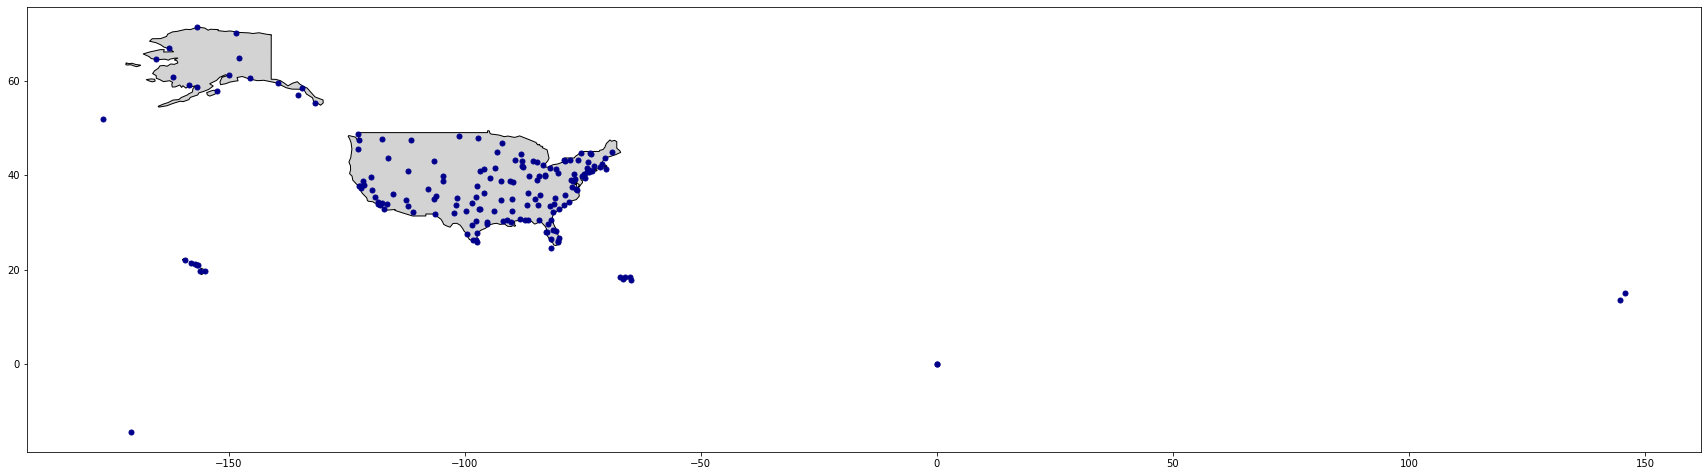

In [29]:
ax = world[world.iso_a3 == 'USA'].plot(
    color='lightgrey', edgecolor='black', figsize=(30,10))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='darkblue', markersize=25)

plt.show()

In [30]:
airports_loc.select('country').distinct().show()

+---------------+
|        country|
+---------------+
|    VIRGIN ISL.|
|          SAMOA|
|    PUERTO RICO|
|MARIANA ISLANDS|
|            USA|
+---------------+



In the next two questions, we will want to get an understanding of ticket prices based on flight distance.  
## Question 3 (2 points)


**Task : To do that we first need to get and understanding of the flight distance distribution.**

We want to display an histogram of flight distances. To do this :  
- use ```bins = np.logspace(np.log10(min_miles_distance), np.log10(max_miles_distance), num=10, dtype='int32')```

- then use numpy digitize function inside a spark UDF to create the buckets.

- buckets should be displayed in the correct order, and displayed like this : [min;max]








#### Answer and code :

We use again our original dataframe ```flights_df```. Because we want to keep only one flight by pair (Origin, Destination), we wanted to use ```dropDuplicates()``` so that we only have the rows in which we are interested. Because we only care about the distances (and not the price for instance), we don't have to choose one particular row to keep (within all the rows for a same travel). But finally, because we need to compute the average price per bucket in the next question, we should already consider the average price for each flight here (even if for this question we won't use the prices).

For that, we will use a method (that we are going to use again in questions 5 and 6) in which we aggregate our rows according to windows. It will be explained further in question 5 and 6. This method allows us to keep all the columns needed (without having to do a group by and a join with the initial dataframe). Because we want the average price for each window (ie for which pair (origin, dest)), Spark would probably perform a shuffle in order to have all the rows of interest on the same worker.

We now have 8471 distincts routes.

As we saw before, there's not as many origin airports as destination airports. Thus there may exist some outwards routes and not the return. That's why we keep all the oriented flights (instead of considering the routes as non oriented edges and only keep distincts ones).

Now that we have are distincts routes, we can compute the min and maximum distance. We do it with a max/min aggregation and then ```collect()``` the only remaining value. We observe that the minimum is 11 Miles, and the max 5095.

Then we can calculate the bins using the given function in class, and write the correct intervals into a list.

We then use an UDF function (using ```np.digitize```) in order to assign a bucket to each flight. We add a column in our dataframe with the bucket index.

Now we group our rows by the bucket index while counting how many rows are going in each bucket. We can then convert the dataframe to a pandas dataframe because we have very few rows.

Then, we assign each bucket to its 'name' (which is simply its interval). 

Finally, we just have to plot it using a barchart.

We note that the values distribution looks like a log-gaussian (considering that the bins are computed logarithmically).

In [31]:
#unique_flights_df = flights_df.dropDuplicates(['Origin','Dest'])

First, we compute the average price for each pair(Origin, Dest).

In [32]:
w = Window.partitionBy('Origin','Dest')

unique_flights_df = flights_df.withColumn('avg_price', F.avg('PricePerTicket').over(w))


Then we only keep columns of interest.

In [33]:
unique_flights_df = unique_flights_df.select('Origin','Dest','Miles','avg_price')

Finally, we drop the duplicates.

In [34]:
unique_flights_df = unique_flights_df.dropDuplicates(['Origin','Dest']).withColumn('avg_price', F.round('avg_price',2))

In [35]:
unique_flights_df.show(5)

+------+----+------+---------+
|Origin|Dest| Miles|avg_price|
+------+----+------+---------+
|   ABE| ATL| 692.0|   243.15|
|   ABE| FLL|1041.0|   100.49|
|   ABI| DFW| 158.0|   613.88|
|   ABQ| AGS|1412.0|   354.44|
|   ABQ| AUS| 619.0|   140.13|
+------+----+------+---------+
only showing top 5 rows



In [36]:
unique_flights_df.count()

8471

In [37]:
min_miles_distance = int(unique_flights_df.agg({'Miles': 'min'}).collect()[0]["min(Miles)"])

max_miles_distance = int(unique_flights_df.agg({'Miles': 'max'}).collect()[0]["max(Miles)"])

avg_miles_distance = int(unique_flights_df.agg({'Miles': 'avg'}).collect()[0]["avg(Miles)"])


In [38]:
print(f'The minimum distance is {min_miles_distance} while the maximum is {max_miles_distance}')

The minimum distance is 11 while the maximum is 5095


In [39]:
avg_miles_distance

1200

In [40]:
bins = np.logspace(np.log10(min_miles_distance), np.log10(max_miles_distance), num=10, dtype='int32')

In [41]:
bins

array([  10,   21,   43,   85,  168,  332,  658, 1302, 2576, 5095],
      dtype=int32)

In [42]:
bin_range = []
for i in range(len(bins)-1):
  name = f"]{bins[i]};{bins[i+1]}]"
  bin_range.append(name)

print(bin_range)

[']10;21]', ']21;43]', ']43;85]', ']85;168]', ']168;332]', ']332;658]', ']658;1302]', ']1302;2576]', ']2576;5095]']


In [43]:
#@udf(returnType=IntegerType())
def create_buckets(miles):
  return int(np.digitize(miles, bins, right=True))

create_buckets_udf = udf(create_buckets, IntegerType())

In [44]:
unique_flights_df = unique_flights_df.withColumn("Miles_bucket", create_buckets_udf("Miles"))

In [45]:
flights_pd = unique_flights_df.groupby("Miles_bucket").count().toPandas()
flights_pd = flights_pd.set_index('Miles_bucket').sort_index()
flights_pd['name']= bin_range

In [46]:
flights_pd

,count,name
Miles_bucket,,
1,2,]10;21]
2,6,]21;43]
3,19,]43;85]
4,106,]85;168]
5,518,]168;332]
6,1571,]332;658]
7,3308,]658;1302]
8,2603,]1302;2576]
9,338,]2576;5095]


<BarContainer object of 9 artists>

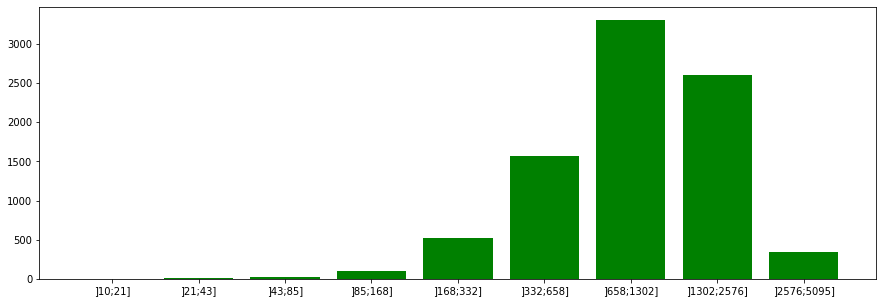

In [47]:
plt.figure(figsize=(15,5))
plt.bar(flights_pd['name'], flights_pd['count'], color='green')

## Question 4 (3 points)
 

**Task : Display the average flight fares for each distance bucket.  
Graph should also contain the confidence intervals.  
Buckets should be displayed in the correct order, and displayed like this : $[min;max]$  
Interpret the results.**

#### Answer and code :

This time we also need price informations. Thanks to what we did in question 4, we already have the average price per flight (if we didn't do it, we would have consider the first price of the dataset for each pair instead of the average). So now, we just have to aggregate it per bucket.

To do so, we group by bucket while aggregating the values to compute the average price(which is the average of the average), the standard deviation and the count. 

Once again we suppose that a shuffle would be perfom in order to have all the rows from each bucket on the same worker, so that the aggregation is much easier.


We then convert it into a pandas dataframe.

Then we compute $1.96 * std/sqrt(N)$ for each row, which will be used to compute the confidence interval (95%).

Then we do the same manipulation as in the previous question to associate each bucket to its interval and then plot it in a bar chart.

As there are very few values in the 3 first buckets 2, 6 and 19), we cannot really interpret the confidence interval (the number of samples should be greater than 30) and the mean is not extremely significant.
Nevertheless, we note that the mean price for almost all buckets except the last one is (globally) around 200. The mean for the last bucket differs significantly and has a mean price of 418. Thus we can think that the prices do not really depend on the distances as we can see that except for very long distances the prices are not really differents. For very long flights (ie for the last buckets which contains 338 flights between 2576 and 5095 Miles) the prices are much higher. We can see it as a threshold above which there's a signifiant raise of price.

In [48]:
unique_flights_df.show(5)

+------+----+------+---------+------------+
|Origin|Dest| Miles|avg_price|Miles_bucket|
+------+----+------+---------+------------+
|   ABE| ATL| 692.0|   243.15|           7|
|   ABE| FLL|1041.0|   100.49|           7|
|   ABI| DFW| 158.0|   613.88|           4|
|   ABQ| AGS|1412.0|   354.44|           8|
|   ABQ| AUS| 619.0|   140.13|           6|
+------+----+------+---------+------------+
only showing top 5 rows



In [49]:
prices_df = unique_flights_df.groupby("Miles_bucket").agg(F.round(F.mean('avg_price'),2).alias('mean'),\
                                              F.stddev('avg_price').alias('std'),\
                                              F.count('avg_price').alias('N')).toPandas()

In [50]:
prices_df

,Miles_bucket,mean,std,N
0,1,204.11,11.702617,2
1,6,183.79,67.266215,1571
2,3,182.60,126.703078,19
3,5,202.77,72.103439,518
4,9,418.74,124.011352,338
5,4,216.51,109.372166,106
6,8,268.22,77.495474,2603
7,7,203.02,75.620382,3308
8,2,124.90,20.101554,6


In [51]:
#prices_df['low_IC']= None
#prices_df['up_IC']= None
prices_df['IC']=None

In [52]:
for i in range(len(prices_df)):
  frac = prices_df['std'][i]/np.sqrt(prices_df['N'][i])
  m = prices_df['mean'][i]
  #prices_df['low_IC'][i] = m - 1.96*frac
  #prices_df['up_IC'][i] = m + 1.96*frac
  prices_df['IC'][i]=1.96*frac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
prices_df = prices_df.set_index('Miles_bucket').sort_index()

In [54]:
prices_df['name']= bin_range

In [55]:
prices_df

,mean,std,N,IC,name
Miles_bucket,,,,,
1,204.11,11.702617,2,16.219,]10;21]
2,124.90,20.101554,6,16.084593,]21;43]
3,182.60,126.703078,19,56.972652,]43;85]
4,216.51,109.372166,106,20.821401,]85;168]
5,202.77,72.103439,518,6.209365,]168;332]
6,183.79,67.266215,1571,3.326327,]332;658]
7,203.02,75.620382,3308,2.576987,]658;1302]
8,268.22,77.495474,2603,2.977113,]1302;2576]
9,418.74,124.011352,338,13.220844,]2576;5095]


<BarContainer object of 9 artists>

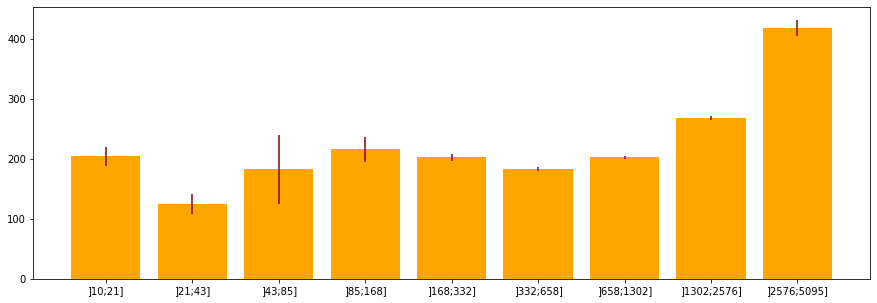

In [56]:
plt.figure(figsize=(15,5))
plt.bar(prices_df['name'], prices_df['mean'], color='orange', yerr=prices_df['IC'], ecolor = 'darkred')

## Question 5 (4 points)


**Task : For the remainder of the notebook, we will only take care of the average price of each route.  
Our goal is to find cheap combinations of flights to travel from one place to another.  
First, we want to build a dataframe named 'cheapest_routes_df' containing the cheapest price to go from one place to another, with one or zero waypoint. Dataframe should look like this (Waypoints column can be empty)** :  

Origin  | Destination | Waypoints | TotalPrice
-------------------|------------------|---|---
ACY       | MOB | ATL | 323.0
Row 2, Col 1       | Row 2, Col 2 | | 89.0
  
Is it interesting to consider waypoints to go from one place to another ?  

##### Answer and code :

First of all, we need again our dataframe with every route possible and the average price. We then use **unique_flights_df** renamed as **flights_prices** and we keep only the 3 columns of interest.

Then, we first compute the flights with exactly one waypoint. We select the 'Origin', 'Dest' and 'PricePerTicket' columns of the flights_prices dataframe and make an inner join on himself with an 'Origin' column joining a 'Dest' column to become the 'Waypoints' column. We name this dataframe __one_waypoint__.
For clarity, we duplicated the original dataframe into 'first_part' (having an origin and a waypoint) and 'second_part'(having a waypoint and a destination), so that we only have to join it on the 'waypoint' column. 

We will then compute the price of this travel with a single waypoint by adding the 2 prices of each individual flight together. We name this dataframe __one_waypoint_price__.

We then reorder the columns of the flights_prices dataframe to have a dataframe with all the travels without any waypoint and we add an empty column named 'Waypoints' to this dataframe without waypoint to be able to make an union between the two dataframes. We rename this dataframe __no_waypoint__.

Now, we have the dataframe routes_df, which represent all the possibilities with or without waypoint. This dataframe contains 635152 rows (which means that there are 635152 possibilities to do 8471 travels).

Finally, we compute the cheapest routes in the absolute for each tuple('Origin', 'Dest')amon all the possibilities with or without waypoint. We name this dataframe __cheapest_routes_df__. To do so, we create a window for each pair and then we look only in the rows of the window to find which route is the cheapest one. The aggregation creates a new column with this min value, then we just have to keep the row which accomplished this min value.

We finally have our **cheapest_routes_df** !

To ensure the usefulness of our computation, we compute the number of cheapest routes in the dataframe cheapest_routes_df that have '__null__' values in the column 'Waypoint', which mean that the cheapest routes directly came from the flight_df dataframe. We obtain that we have $6229$ routes of the $48941$ routes of the cheapest_routes_df dataframe that have no way points. It is obvious that the cheapest route between two airports that are not directly connected will contain a waypoint. Nevertheless, there are 8471 pairs of airports that are directly connected, which means that for some of them, we found a cheaper route with a waypoint.

In the end, we just dropped the rows with the same origin and destination.

In [57]:
unique_flights_df.show(5)

+------+----+------+---------+------------+
|Origin|Dest| Miles|avg_price|Miles_bucket|
+------+----+------+---------+------------+
|   ABE| ATL| 692.0|   243.15|           7|
|   ABE| FLL|1041.0|   100.49|           7|
|   ABI| DFW| 158.0|   613.88|           4|
|   ABQ| AGS|1412.0|   354.44|           8|
|   ABQ| AUS| 619.0|   140.13|           6|
+------+----+------+---------+------------+
only showing top 5 rows



In [58]:
flights_prices = unique_flights_df.select('Origin', 'Dest', 'avg_price')

In [59]:
flights_prices.count()

8471

We create two copies of the flights_prices dataframe to make an inner join between them and create a dataframe with all the possible routes with a waypoint.

In [60]:
first_part = flights_prices.withColumnRenamed('Dest','Waypoint')
first_part = first_part.withColumnRenamed('avg_price','avg_price1')
second_part = flights_prices.withColumnRenamed('Origin','Waypoint')

In [61]:
one_waypoint = first_part.join(second_part,on="Waypoint", how='INNER')

In [62]:
one_waypoint.show(2)

+--------+------+----------+----+---------+
|Waypoint|Origin|avg_price1|Dest|avg_price|
+--------+------+----------+----+---------+
|     DLG|   ANC|    231.39| ANC|   234.16|
|     PSE|   MCO|    191.39| JFK|   199.12|
+--------+------+----------+----+---------+
only showing top 2 rows



In [63]:
one_waypoint_price = one_waypoint.withColumn("Price", F.round(one_waypoint.avg_price1 + one_waypoint.avg_price,2)).select('Origin','Waypoint','Dest','Price')

We then add all the flights without waypoint to add them to our dataframe with the routes with a waypoint.

In [64]:
no_waypoint = flights_prices.withColumn('Waypoint',lit(None)).withColumnRenamed('avg_price','Price')

We reorganise the dataframe to be able to make an union between the two dataframes.

In [65]:
no_waypoint = no_waypoint.select("Origin","Waypoint","Dest","Price")

In [ ]:
one_waypoint_price.show(2)

In [ ]:
no_waypoint.show(2)

In [ ]:
routes_df = one_waypoint_price.union(no_waypoint)

In [ ]:
routes_df.count()

In [ ]:
routes_df.show(5)

+------+--------+----+------+
|Origin|Waypoint|Dest| Price|
+------+--------+----+------+
|   ANC|     DLG| ANC|465.55|
|   MCO|     PSE| JFK|390.51|
|   JFK|     PSE| JFK|409.09|
|   USA|     MSY| ABQ|343.42|
|   TPA|     MSY| ABQ|397.15|
+------+--------+----+------+
only showing top 5 rows



We only keep the tuple('Origin', 'Dest') with the lowest price to know which combination is the best.

In [ ]:
w = Window.partitionBy('Origin','Dest')

cheapest_routes_df = routes_df.withColumn('TotalPrice', F.min('Price').over(w))\
    .where(F.col('Price') == F.col('TotalPrice'))\
    .drop('Price')

In [ ]:
cheapest_routes_df.show()

+------+--------+----+----------+
|Origin|Waypoint|Dest|TotalPrice|
+------+--------+----+----------+
|   ABE|     ATL| AGS|    471.39|
|   ABE|     FLL| AMA|    385.39|
|   ABE|    null| ATL|    243.15|
|   ABE|     PGD| ATW|    226.23|
|   ABE|     PIE| AUS|    198.22|
|   ABE|     SFB| AVP|    192.29|
|   ABE|     PIE| AZA|    221.63|
|   ABE|     MYR| BDL|     178.5|
|   ABE|     MYR| BLV|     165.4|
|   ABE|     MYR| BNA|    155.84|
|   ABE|     ORD| BRO|    437.37|
|   ABE|     ATL| BTR|    487.02|
|   ABE|     FLL| BTV|    301.35|
|   ABE|     FLL| BUF|    280.22|
|   ABE|     FLL| BUR|    353.54|
|   ABE|     MYR| BWI|    175.11|
|   ABE|     FLL| CAK|    199.05|
|   ABE|     PIE| CHA|     191.2|
|   ABE|     ATL| CHO|    453.94|
|   ABE|     MYR| CLE|    167.05|
+------+--------+----+----------+
only showing top 20 rows



We compute the total number of routes we finally have. We then compare it to the number of routes in this dataframe that don't have a waypoint. Finally we observe that our pain was not vain and we definitly found cheaper options to travel from an airport to another.

In [ ]:
cheapest_routes_df.count()

48941

In [ ]:
cheapest_routes_df = cheapest_routes_df.where(cheapest_routes_df.Origin != cheapest_routes_df.Dest)

In [ ]:
cheapest_routes_df.count()

48688

In [ ]:
cheapest_routes_df.filter(cheapest_routes_df["Waypoint"].isNull() | F.isnan(cheapest_routes_df["Waypoint"])).count()

6229

## Question 6 (6 points)

**Task : Now we want to create the dataframe with cheap combinations of flights from one place to another, but there is no longer any limitation on the amount of waypoints.**  
Let $Routes_{k}$ designate the dataframe that contains cheapest routes for at most $k$ waypoints.  
This dataframe contains a column named 'Waypoints', containing an array of waypoints.  
Then:  
- Define a function that computes $Routes_{k+1}$ from $Routes_{k}$ and $Routes_{0}$.  
- Test it on a simple dataset made of three rows, built with $spark.sparkContext.parallelize$.  
- Use it iteratively to build what we want.  
- At each step, measure the amount of routes with k waypoints.  
- What is the stopping criterion ?  
- Measure the execution time of each step.  
- What if we want to execute the iterations up to $k=15$ ?  
- Explain what happens, and find a solution to approximately have the same execution time at each iteration.  
- Analyze the results obtained for $Routes_{maxK}$
- Analyze the euros spared, putting them in front of the extra miles traveled.


#### Answer and code :
We first computed Routes0 which is nothing but the same dataframe as before with the routes ans average prices. We just rename and reorganise the columns for simplicity later.

The function route_step(rsk,rs0) allows us to compute $Routes_{k+1}$ using $Routes_{k}$ and $Routes_{0}$. 
It uses three steps :

- The function jointure(rsk,rs0) makes an inner join between $Routes_{k}$ and $Routes_{0}$ on $Routes_{k}$.Dest and $Routes_{0}$.Origin and computes the price of the newly built route. Finaly it adds $Routes_{k}$.Dest to $Routes_{k+1}$.Waypoints and define $Routes_{k+1}$.Dest with the value $Routes_{0}$.Dest. It also compute the new price and reorganize the dataframe. In the end, this step gives us a dataframe of all the possibilities with exactly one more waypoint than we add before.

- Then we perform an union between this previous dataframe and Routesk which represent the possibilities with no more waypoint. Now we have a dataframe with all the possibilites with or without supplementary waypoint.

- The function min_price(routes) computes the cheapest routes in the given dataframe among all the possibilities.

Actually we just performed the exactly same steps as in question 5.

In [ ]:
routes0 = flights_prices.withColumnRenamed('Origin', 'Origin0')\
                        .withColumnRenamed('Dest', 'Dest0')\
                        .withColumnRenamed('avg_price', 'Price0')\
                        .select("Origin0","Dest0","Price0")

In [ ]:
routes0.show(5)

+-------+-----+------+
|Origin0|Dest0|Price0|
+-------+-----+------+
|    ABE|  ATL|243.15|
|    ABE|  FLL|100.49|
|    ABI|  DFW|613.88|
|    ABQ|  AGS|354.44|
|    ABQ|  AUS|140.13|
+-------+-----+------+
only showing top 5 rows



In [ ]:
from pyspark.sql.types import ArrayType, StringType, StructType, StructField

In [ ]:
def jointure(rsk, rs0):
  '''
  Cette fonction fait la jointure entre Routes_k et Routes_0,
  Puis modifie le résultat de cette jointure pour garder seulement ce qu'on veut.
  Renvoie le dataframe avec toutes les possibilités en ajoutant une escale
  depuis Routes_k

  '''
  #We compute all the possibilities with one more waypoint
  one_more_wp = rsk.join(rs0, rsk['Dest'] == rs0['Origin0'], how='INNER')

  #update liste waypoints
  #On transforme Dest en array
  one_more_wp = one_more_wp.withColumn('Dest', F.array('Dest'))
  #On fait l'union
  one_more_wp = one_more_wp.withColumn('Waypoints', F.array_union('Waypoints','Dest'))

  #Drop de la destination intermédiaire qui est devenue un waypoint
  one_more_wp = one_more_wp.drop('Dest')

  #Mise à jour de la nouvelle destination finale
  one_more_wp = one_more_wp.withColumnRenamed('Dest0','Dest')

  #Somme des 2 prix
  one_more_wp = one_more_wp.withColumn('FinalPrice', F.round(one_more_wp.Price + one_more_wp.Price0,2))
  

  #Réorganisation et select des colonnes
  one_more_wp = one_more_wp.select('Origin','Waypoints','Dest','FinalPrice')
  one_more_wp = one_more_wp.withColumnRenamed('FinalPrice','Price')

  return one_more_wp

In [ ]:
def min_price(routes):
  
  #On veut grouper par origine et destination (pour ensuite trouver le meilleur prix)
  w = Window.partitionBy('Origin','Dest')

  #On cherche le meilleur prix sur cette fenêtre
  #On ne garde que la ligne avec le meilleur prix
  cheapest_routes_df = routes.withColumn('TotalPrice',\
                                            F.min('Price').over(w))\
                                            .where(F.col('Price') == F.col('TotalPrice'))

  #On ne garde que les colonnes qui nous intéressent
  cheapest_routes_df = cheapest_routes_df.drop('Price')

  return cheapest_routes_df

In [ ]:
def routes_step(rsk,rs0):

  #Toutes les possibilités avec une escale de plus
  one_more_wp = jointure(rsk, rs0)

  #On rajoute ces possibilités à la suite des possibilités qu'on avait déjà
  zero_or_one_more = rsk.unionByName(one_more_wp)

  #On trouve le meilleur prix parmi les possibilités
  rsk1 = min_price(zero_or_one_more)

  return rsk1

In [ ]:
#- Test it on a simple dataset made of three rows, built with $spark.sparkContext.parallelize$.

test_data = [["ABE", ['ABC','BNA'], "PHL", 452.5], ['FGP', ['DFS'], 'ORD', 500.32], ['PHL', [], 'PNS', 5.]]
test_columns = ['Origin', 'Waypoints', 'Dest', 'Price']

test_routes_df = spark.sparkContext.parallelize(test_data).toDF(test_columns)

test_routes_df.show()

+------+----------+----+------+
|Origin| Waypoints|Dest| Price|
+------+----------+----+------+
|   ABE|[ABC, BNA]| PHL| 452.5|
|   FGP|     [DFS]| ORD|500.32|
|   PHL|        []| PNS|   5.0|
+------+----------+----+------+



In [ ]:
rep = routes_step(test_routes_df, routes0)

In [ ]:
rep.show()

+------+---------------+----+----------+
|Origin|      Waypoints|Dest|TotalPrice|
+------+---------------+----+----------+
|   ABE|[ABC, BNA, PHL]| ABQ|    677.65|
|   ABE|[ABC, BNA, PHL]| ATL|    660.43|
|   ABE|[ABC, BNA, PHL]| AUS|    721.44|
|   ABE|[ABC, BNA, PHL]| BDL|    778.89|
|   ABE|[ABC, BNA, PHL]| BHM|    594.13|
|   ABE|[ABC, BNA, PHL]| BNA|    646.24|
|   ABE|[ABC, BNA, PHL]| BOI|    757.19|
|   ABE|[ABC, BNA, PHL]| BOS|     657.3|
|   ABE|[ABC, BNA, PHL]| BTV|    758.31|
|   ABE|[ABC, BNA, PHL]| BUR|    785.66|
|   ABE|[ABC, BNA, PHL]| CHS|    605.29|
|   ABE|[ABC, BNA, PHL]| CLE|    783.81|
|   ABE|[ABC, BNA, PHL]| CLT|    759.88|
|   ABE|[ABC, BNA, PHL]| CMH|    790.78|
|   ABE|[ABC, BNA, PHL]| CVG|    522.24|
|   ABE|[ABC, BNA, PHL]| DAL|    654.92|
|   ABE|[ABC, BNA, PHL]| DCA|    788.89|
|   ABE|[ABC, BNA, PHL]| DEN|    690.68|
|   ABE|[ABC, BNA, PHL]| DFW|    741.02|
|   ABE|[ABC, BNA, PHL]| DSM|    641.41|
+------+---------------+----+----------+
only showing top

In [ ]:
# We build a funtion to asses if 2 dataframes are equal to use t as a stopping criterion

def are_equal(df1, df2):
    # we sort columns to ensure that they are both in the same order
    cols_1 = sorted(df1.columns)
    cols_2 = sorted(df2.columns)

    # We do an aggregation to prevent problems with duplicates rows
    df_1 = df1.groupby(cols_1).agg(F.count(cols_1[1]))
    df_2 = df2.groupby(cols_2).agg(F.count(cols_2[1]))

    # We perform an equality check with a row count
    if df_1.subtract(df_2).rdd.isEmpty():
        return df_2.subtract(df_1).rdd.isEmpty()
    return False

The function compute_k_steps(k, rs0, origin, destination) computes the cheapest routes between an origin and a destination whith a number of waypoints that may be between $0$ and $k$. We store the finished routes, routes between the origin and destination parameters, in the variable __rep_df__. We store the unfinished routes in the variable __rsk__. 

We have two terminal conditions : we stop either if our dataframes are the same from a step to the following step or if at the end of a step we only have terminated travels.

After each step computed with the route_step function, we test the equality between the step $k$ and $k-1$. We then add terminated routes to the rep_df dataframe and substract these routes from the rsk dataframe. We then make an union between the dataframe rsk of the step $k-1$ and the dataframe of the step $k$ and only keep the cheapest tuples with the function min_price. This union between the two dataframes allow us to ensure that we iteratively keep the cheapest tuples we could find.

At the end of the function, we ensure to return the cheapest route between the origin and destination passed as an argument of the function.

In [ ]:
# Use it iteratively to build what we want.

def compute_k_steps(k, rs0, origin, destination):
    # On crée notre dataframe de réponse
    schema = StructType([
        StructField('Origin', StringType(), True),
        StructField('Waypoints', ArrayType(StringType()), True),
        StructField('Dest', StringType(), True),
        StructField('Price', IntegerType(), True)
        ])
    rep_df = spark.createDataFrame([], schema)
    print("rep_df has been built")

    # on initialise rsk avec les lignes de rs0 qui on pour Origin l'argument 'origin' de la fonction
    rsk = rs0.filter(rs0.Origin0 == origin)
    rsk = rsk.withColumnRenamed('Origin0', 'Origin')\
             .withColumnRenamed('Dest0', 'Dest')\
             .withColumnRenamed('Price0', 'Price')\
             .select("Origin","Dest","Price")
    print("Rsk has been built")

    # On crée une colonne Waypoints de type arrayType<str> pour y stocker les waypoints
    rsk = rsk.withColumn("Waypoints", F.array())
    print("rsk waypoints built")

    for i in range(k):
        start = time.time()
        # we make a step
        rsk_new = routes_step(rsk, rs0).withColumnRenamed("TotalPrice", "Price")

        if are_equal(rsk_new, rsk):
            continue

        # we add the terminated travels to our response dataframe
        terminated_travels = rsk_new.filter(rsk_new.Dest == destination)
        rep_df = rep_df.unionByName(terminated_travels)
    
        # We substract the terminated travels from our routes_k dataframe
        rsk_new = rsk_new.subtract(terminated_travels)

        # We make an union with the routes of step k-1 and k to keep the lowest price after a new step
        rsk = rsk.unionByName(rsk_new)

        # We select the shortest path for each tuple (Origin, Dest)
        rsk = min_price(rsk)
        rsk = rsk.withColumnRenamed("TotalPrice", "Price")
        
        print(f"At step {i}, we have {rsk_new.count()} routes with length at most {i+1}.")

        # We print the time that the step took
        print(f"The step {i} took {time.time()-start}s.")
    
    # we return the cheapest routes
    return min_price(rep_df)

In [ ]:
cheapest_routes_PBI_DCA = compute_k_steps(4, routes0, "PBI", "DCA")

rep_df has been built
Rsk has been built
rsk waypoints built
At step 0, we have 225 routes with length at most 1.
The step 0 took 134.58200693130493s.
At step 1, we have 258 routes with length at most 2.
The step 1 took 697.2174727916718s.


Py4JJavaError: ignored

With the routes0 dataframe, we were able to achieve an average 3minutes per step of the algorithm, but we were unable to achieve the desired number of iteration because of the exponential growth of the dataframe with inner join at each step. However we tried to only keep the cheapest routes each time to avoid duplicates in the dataset and keep it light but it looked like the dataframe was still growing iteration after iteration.

The problem that we identified was that there are aproximately 270 possible origin and/or destination for each steps, which means that if we cannot minigate the number of possible routes at each step, we can have at each step $k$ up to $270^k$ possible routes in the dataframe which can lead to memory overflow and very long computational time.